<p style="color:#336E7B; font-size:300%; font-family:Impact; padding-bottom:10px">Image Manipulation and Segmentation</p>
<p style="color:#34495E; font-size:200%; font-family:Impact; line-height: 50px";>Sean Wade</p>
<hr style="height: 2px">

In [69]:
%matplotlib inline

In [88]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import linalg
from scipy import linalg as la
from matplotlib import pyplot as plt

<div style="background-color: #E3F8FA; width: 100%; padding:26px; border">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">The Laplacian Matrix</span></b>
<p style="line-height: 25px">
This matrix can give us many interseting properties of a graph.  It is calculated by the difference of the adjaceny matrix and the degree matrix
</p>
</div>

In [54]:
def laplacian(A):
    '''
    Compute the Laplacian matrix of the adjacency matrix A.
    Inputs:
        A (array): adjacency matrix for undirected weighted graph,
             shape (n,n)
    Returns:
        L (array): Laplacian matrix of A
        
    '''
    m, n = A.shape
    values = np.sum(A, 0)
    D = values * np.eye(n)
    return D - A

<div style="background-color: #E3F8FA; width: 100%; padding:26px; border">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Connectivity</span></b>
<p style="line-height: 25px">
One application of the laplacian matrix is that it provides an easy way to find out if a graph is connected.  A graph is conneceted if the second smallest eigenvalue of the laplacian is positive.
</p>
</div>

In [55]:
def secondEigenvalue(A):
    '''
    Compute the second smallest eigenvalue of the adjacency matrix A.
    Inputs:
        A (array): adjacency matrix for undirected weighted graph,
             shape (n,n)
    Returns:
        lambda (float): the second of the eigenvalues of L, when they
            arranged least to greatest.  Only return the real part.
    '''
    m, n = A.shape
    L = laplacian(A)
    ev = sorted(la.eigvalsh(L))
    return ev[2]    

<div style="background-color: #E3F8FA; width: 100%; padding:26px; border">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Image Segmentation</span></b>
<p style="line-height: 25px">
Image segmentation is the process of finding natural boundaries in an image.  We use a technique developed by Jianbo Shi and Jitendra Malik where each pixel is a node in a graph.  We get the adjacency matrix, flatten it, and minimize the cut distance.
</p>
</div>

In [101]:
# Helper function used to convert the image into the correct format.
def getImage(filename='dream.png'):
    '''
    Reads an image and converts the image to a 2-D array of brightness
    values.
    
    Inputs:
        filename (str): filename of the image to be transformed.
    Returns:
        img_color (array): the image in array form
        img_brightness (array): the image array converted to an array of
            brightness values.
    '''
    img_color = plt.imread(filename)
    img_brightness = (img_color[:,:,0]+img_color[:,:,1]+img_color[:,:,2])/3.0
    return img_color,img_brightness

In [65]:
# Helper function for computing the adjacency matrix of an image
def getNeighbors(index, radius, height, width):
    '''
    Calculate the indices and distances of pixels within radius
    of the pixel at index, where the pixels are in a (height, width) shaped
    array. The returned indices are with respect to the flattened version of the
    array. This is a helper function for adjacency.
    
    Inputs:
        index (int): denotes the index in the flattened array of the pixel we are 
                looking at
        radius (float): radius of the circular region centered at pixel (row, col)
        height, width (int,int): the height and width of the original image, in pixels
    Returns:
        indices (int): a flat array of indices of pixels that are within distance r
                   of the pixel at (row, col)
        distances (int): a flat array giving the respective distances from these 
                     pixels to the center pixel.
    '''
    # Find appropriate row, column in unflattened image for flattened index
    row, col = index/width, index%width
    # Cast radius to an int (so we can use arange)
    r = int(radius)
    # Make a square grid of side length 2*r centered at index
    # (This is the sup-norm)
    x = np.arange(max(col - r, 0), min(col + r+1, width))
    y = np.arange(max(row - r, 0), min(row + r+1, height))
    X, Y = np.meshgrid(x, y)
    # Narrows down the desired indices using Euclidean norm
    # (i.e. cutting off corners of square to make circle)
    R = np.sqrt(((X-np.float(col))**2+(Y-np.float(row))**2))
    mask = (R<radius)
    # Return the indices of flattened array and corresponding distances
    return (X[mask] + Y[mask]*width, R[mask])


<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Creating the adjacency matrix for an image</span></b>

In [89]:
def adjacency(img_brightness, radius = 5.0, sigma_I = .15, sigma_d = 1.7):
    '''
    Compute the weighted adjacency matrix for
    the image given the radius. Do all computations with sparse matrices.
    Also, return an array giving the main diagonal of the degree matrix.
    
    Inputs:
        img_brightness (array): array of brightnesses given by the function getImage()
        radius (float): maximum distance where the weight isn't 0
        sigma_I (float): some constant to help define the weight
        sigma_d (float): some constant to help define the weight
    Returns:
        W (sparse array(csc)): the weighted adjacency matrix of img_brightness,
            in sparse form.
        D (array): 1D array representing the main diagonal of the degree matrix.
    '''
    h, w = img_brightness.shape
    I = img_brightness.flatten()
    n = I.shape[0]
    W = sp.sparse.lil_matrix((n,n))
    D = np.zeros(n)
    
    for p in xrange(n):
        indices, distance = getNeighbors(p, radius, w, h)
        for i in xrange(len(indices)):
            W[p, indices[i]] = np.exp(-(abs(I[p] - I[indices[i]])/(sigma_I**2))-(distance[i]/sigma_d**2))
        D[p] = W[p].sum()
        
    return W.asformat('csc'), D



In [99]:
def segment(img_brightness):
    '''
    Compute and return the two segments of the image as described in the text. 
    Compute L, the laplacian matrix. Then compute D^(-1/2)LD^(-1/2),and find
    the eigenvector corresponding to the second smallest eigenvalue.
    Use this eigenvector to calculate a mask that will be usedto extract 
    the segments of the image.
    Inputs:
        img_brightness (array): an array of brightnesses given by the function
            getImage().
    Returns:
        seg1 (array): an array the same size as img_brightness, but with 0's
                for each pixel not included in the positive
                segment (which corresponds to the positive
                entries of the computed eigenvector)
        seg2 (array): an array the same size as img_brightness, but with 0's
                for each pixel not included in the negative
                segment.
    '''
    m, n = img_brightness.shape
    A, D = adjacency(img_brightness)
    d = 1/np.sqrt(D)
    d = sp.sparse.spdiags(d, 0, A.shape[0], A.shape[1])
    D = sp.sparse.spdiags(D, 0, A.shape[0], A.shape[1])
    L = D - A
    
    c = d.dot(L)
    c = np.dot(c, d)
    e_val, e_vec = sp.sparse.linalg.eigs(c, which='SR')
    mask = e_vec[:,1]
    size = mask.shape[0]
    pos, neg = np.zeros(size), np.zeros(size)
    for x in xrange(size):
        if mask[x] > 0:
            pos[x] = 1
        elif mask[x] < 0:
            neg[x] = 1
    return np.reshape(pos, (m,n)), np.reshape(neg, (m,n))
    


<b><span style="color:#04353B; font-size:150%; font-family:Maraco">
Display the 2-tone segmentation of the image</span></b>

In [ ]:
def displayPosNeg(img_color,pos,neg):
    '''
    Displays the original image along with the positive and negative
    segments of the image.
    
    Inputs:
        img_color (array): Original image
        pos (array): Positive segment of the original image
        neg (array): Negative segment of the original image
    Returns:
        Plots the original image along with the positive and negative
            segmentations.
    '''
    plt.subplot(131)
    plt.imshow(neg)
    plt.subplot(132)
    plt.imshow(pos)
    plt.subplot(133)
    plt.imshow(img_color)
    plt.show()

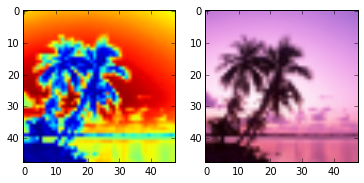

In [106]:
img_color, img_brightness = getImage('dream.png')
plt.subplot(121)
plt.imshow(img_brightness)
plt.subplot(122)
plt.imshow(img_color)

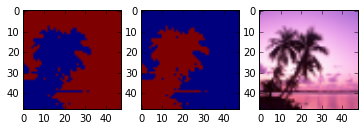

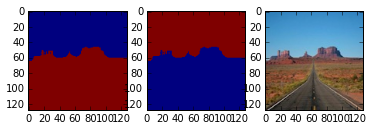

In [108]:
img_color, img_brightness = getImage('dream.png')
pos, neg = segment(img_brightness)
displayPosNeg(img_color, pos, neg)
img_color, img_brightness = getImage('desert_road.png')
pos, neg = segment(img_brightness)
displayPosNeg(img_color, pos, neg)